In [70]:
# import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

# Load Data

In [4]:
df = pd.read_csv('train.csv')

# Data Cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
# Dropping 'Id', since it's just an indexing variable

df.drop(columns=['Id'], inplace=True)

**LotFrontage, Alley, MasVnrType, MasVnrArea, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, Electrical, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond, PoolQC, Fence, MiscFeature** and **MiscFeature** have null values.

For all of the features other than **LotFrontage**, **MasVnrType**, **MasVnrArea**, **GarageYrBlt** and **Electrical** NA is a valid value so we are ignoring them at this stage.

The number of missing values in features are as follows:
1. LotFrontage --> 259
2. GarageYrBlt --> 81
3. MasVnrType --> 8
4. MasVnrArea --> 8
5. Electrical --> 1

LotFrontage has a lot of missing (~18%). So, we cannot just drop all values. 

Since, LotFrontage gives the size of the Street connected to the property and all the entries have a value for the Street feature therefore, these values should not be na or 0

Therefore imputing NA values in LotFrontage with median.

In [7]:
lotFrontageMedian = df.LotFrontage.median()
df.LotFrontage = df.LotFrontage.fillna(lotFrontageMedian)

Dropping all entries where 
MasVnrType, MasVnrArea or Electrical is null. 

These values do not seem to have an appropriate imputation available and have small number of missing values

In [8]:
df.dropna(subset=['MasVnrType', 'MasVnrArea', 'Electrical'],inplace=True)

**GarageYrBlt** values seem to be null whenever there is no garage.

So, imputing the missing values with 0 to keep those entries in.

In [9]:
# Imputing 0 where GarageYrBlt is None

df.GarageYrBlt = df.GarageYrBlt.fillna(0)

In [10]:
# Imputing all remaining na with string 'NA'

df.fillna('NA')

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,MnPrv,NA,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,4,2010,WD,Normal,142125


In [11]:
df.Alley.value_counts()

Grvl    50
Pave    40
Name: Alley, dtype: int64

In [12]:
df.shape

(1451, 80)

In [13]:
def correlationFilter(df: pd.DataFrame, bound: float):
  df_corr = df.corr()
  df_corr_filtered = df_corr[((df_corr >= bound) | (df_corr <= -bound)) & (df_corr !=1.000)]
  df_flattened = df_corr_filtered.unstack().sort_values().drop_duplicates()
  return df_flattened

In [14]:
correlationFilter(df, 0.65)

BedroomAbvGr  TotRmsAbvGrd    0.675590
2ndFlrSF      GrLivArea       0.690403
GrLivArea     SalePrice       0.710073
OverallQual   SalePrice       0.790085
TotalBsmtSF   1stFlrSF        0.818107
GrLivArea     TotRmsAbvGrd    0.825563
GarageCars    GarageArea      0.882470
MSSubClass    MSSubClass           NaN
dtype: float64

TotRmsAbvGrd (Total Rooms Above Ground) is very highly correlated with GrLivArea (Above ground living area) so dropping **TotRmsAbvGrd**


GarageCars (Garage car capacity) is very highly correlated with GarageArea (Size of garage) so dropping **GarageCars**

In [15]:
df.drop(['TotRmsAbvGrd', 'GarageCars'], axis=1, inplace=True)

In [16]:
df.shape

(1451, 78)

# Analysis

In [17]:
# find out the numerical features which are the most correlated with SalePrice

bound = 0.5
SalePrice_Corr = df.corr()['SalePrice']
SalePrice_Corr_High = SalePrice_Corr[((SalePrice_Corr >= bound) | (SalePrice_Corr <= -bound)) & (SalePrice_Corr !=1.000)]
SalePrice_Corr_High.sort_values()

YearRemodAdd    0.507488
YearBuilt       0.523274
FullBath        0.562710
1stFlrSF        0.606969
TotalBsmtSF     0.613299
GarageArea      0.622484
GrLivArea       0.710073
OverallQual     0.790085
Name: SalePrice, dtype: float64

In [18]:
df_high_corr = df[SalePrice_Corr_High.keys()]
df_high_corr

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,GarageArea
0,7,2003,2003,856,856,1710,2,548
1,6,1976,1976,1262,1262,1262,2,460
2,7,2001,2002,920,920,1786,2,608
3,7,1915,1970,756,961,1717,1,642
4,8,2000,2000,1145,1145,2198,2,836
...,...,...,...,...,...,...,...,...
1455,6,1999,2000,953,953,1647,2,460
1456,6,1978,1988,1542,2073,2073,2,500
1457,7,1941,2006,1152,1188,2340,2,252
1458,5,1950,1996,1078,1078,1078,1,240


Looking at some plots between SalePrice and numerical features which are highly correlated with it

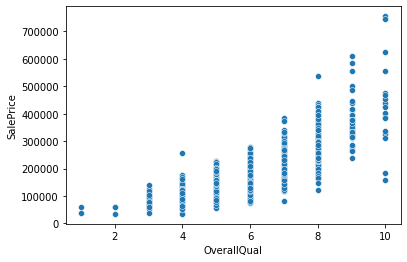

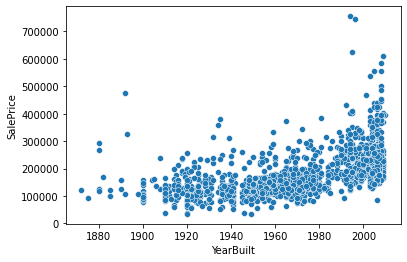

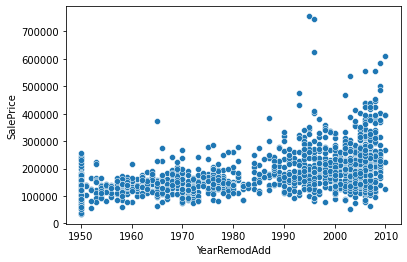

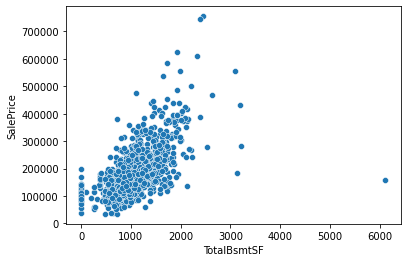

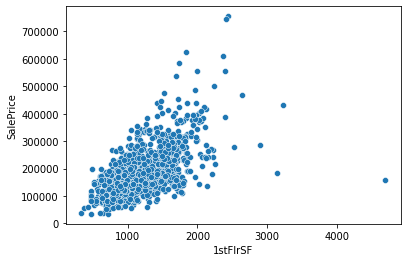

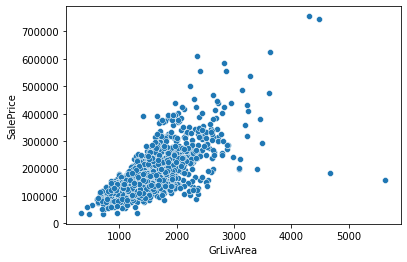

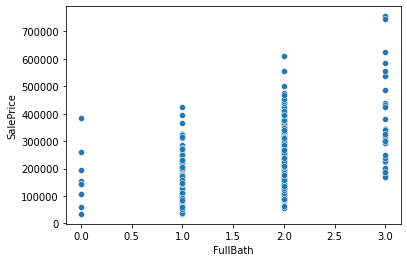

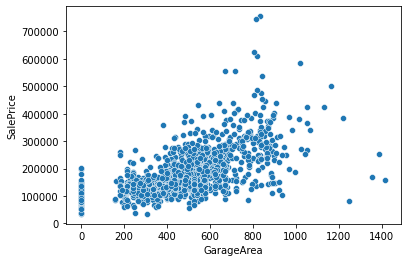

In [19]:
for col in df_high_corr.columns:
  sns.scatterplot(x=df[col], y=df['SalePrice'])
  plt.show()

# Create dummy variables for categorical data

In [20]:
# Create dummy variables to replace categorical values
df = pd.get_dummies(df, dummy_na=True, drop_first=True)
df.head().T

,0,1,2,3,4
MSSubClass,60.0,20.0,60.0,70.0,60.0
LotFrontage,65.0,80.0,68.0,60.0,84.0
LotArea,8450.0,9600.0,11250.0,9550.0,14260.0
OverallQual,7.0,6.0,7.0,7.0,8.0
OverallCond,5.0,8.0,5.0,5.0,5.0
...,...,...,...,...,...
SaleCondition_Alloca,0.0,0.0,0.0,0.0,0.0
SaleCondition_Family,0.0,0.0,0.0,0.0,0.0
SaleCondition_Normal,1.0,1.0,1.0,0.0,1.0
SaleCondition_Partial,0.0,0.0,0.0,0.0,0.0


# Splitting the Data into Train, Validation and Test Sets

In [21]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=100)

In [22]:
train_set.shape, test_set.shape

((1160, 287), (291, 287))

# Rescaling the Features
We will use MinMax scaling.

## Applying the scaling on the train set

In [23]:
scaler = MinMaxScaler()
train_set[train_set.columns] = scaler.fit_transform(train_set[train_set.columns])
train_set.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
count,1160.000000,1160.000000,1160.000000,1160.000000,1160.000000,1160.000000,1160.000000,1160.000000,1160.000000,1160.000000,...,1160.000000,1160.000000,1160.000000,1160.0,1160.000000,1160.000000,1160.000000,1160.000000,1160.000000,1160.0
mean,0.220183,0.167357,0.043276,0.514978,0.512069,0.720265,0.583405,0.065932,0.078090,0.041857,...,0.078448,0.002586,0.870690,0.0,0.003448,0.007759,0.010345,0.826724,0.080172,0.0
std,0.249438,0.076993,0.049920,0.171526,0.156206,0.218107,0.339989,0.116217,0.081836,0.144454,...,0.268992,0.050811,0.335688,0.0,0.058646,0.087779,0.101226,0.378649,0.271677,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.133562,0.028979,0.375000,0.428571,0.594203,0.283333,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
50%,0.176471,0.164384,0.038134,0.500000,0.428571,0.731884,0.716667,0.000000,0.066442,0.000000,...,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
75%,0.294118,0.198630,0.048087,0.625000,0.571429,0.927536,0.900000,0.105625,0.124956,0.000000,...,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


## Dividing train set into X and Y sets for the model building

In [24]:
x_train = train_set.drop("SalePrice", axis = 1)
y_train = train_set["SalePrice"].copy()
x_train.shape, y_train.shape

((1160, 286), (1160,))

## Applying the scaling on the test set

In [25]:
test_set[test_set.columns] = scaler.transform(test_set[test_set.columns])

## Dividing test set into x_test and y_test

In [26]:
x_test = test_set.drop('SalePrice', axis = 1)
y_test = test_set['SalePrice'].copy()

# Model Building

## Linear Regression

In [27]:
# Train linear regression model
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

# Predictions on the basis of the model
lin_y_pred = lin_reg.predict(x_train)

# R2 for the model
lin_reg_r2 = r2_score(y_train, lin_y_pred)

# Making predictions
lin_y_test_pred = lin_reg.predict(x_test)

# R2 for the model on test set
lin_reg_test_r2 = r2_score(y_test, lin_y_test_pred)

print('Linear Regression train R2')
print(lin_reg_r2)

print('Linear Regression test R2')
print(lin_reg_test_r2)

Linear Regression train R2
0.9379502764678775
Linear Regression test R2
-1.4239776135096187e+18


## Ridge Regression

In [117]:
lambdas = [0, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

for i in lambdas:
  ridge_reg = Ridge(alpha = i)
  ridge_reg.fit(x_train, y_train)
  y_pred = ridge_reg.predict(x_train)
  y_test_pred = ridge_reg.predict(x_test)
  print("lambda = " + str(i))
  print("r2 score = " + str(r2_score(y_train, y_pred)))
  print("test r2 score = " + str(r2_score(y_test, y_test_pred)) + '\n')

lambda = 0
r2 score = 0.9326534121582021
test r2 score = -1.8472763637217337e+26

lambda = 0.001
r2 score = 0.9374236188685785
test r2 score = 0.8133985680160116

lambda = 0.01
r2 score = 0.9360723280505857
test r2 score = 0.8714482647515979

lambda = 0.1
r2 score = 0.9281981166344446
test r2 score = 0.8669427319724446

lambda = 1
r2 score = 0.9110848962660644
test r2 score = 0.8798630144236403

lambda = 10
r2 score = 0.8802568837707178
test r2 score = 0.8788835572196201

lambda = 100
r2 score = 0.7833561443811577
test r2 score = 0.7914219816922687

lambda = 1000
r2 score = 0.5571880357799652
test r2 score = 0.5854559922463742



## Lasso Regression

In [118]:
# Applying Lasso Regression with varying the hyperparameter 'lambda'
lambdas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

for i in lambdas:
  lasso_reg = Lasso(alpha = i) # Create a Lasso regression model
  lasso_reg.fit(x_train, y_train) # Train the model
  y_pred = lasso_reg.predict(x_train)
  y_test_pred = lasso_reg.predict(x_test)

  print("lambda = " + str(i))
  print("r2 score = " + str(r2_score(y_train, y_pred)))
  print("test r2 score = " + str(r2_score(y_test, y_test_pred)) + '\n')

lambda = 0.0001
r2 score = 0.9017882745263048
test r2 score = 0.8825291441819844

lambda = 0.001
r2 score = 0.8206794720673554
test r2 score = 0.8286865974940771

lambda = 0.01
r2 score = 0.4493787349568892
test r2 score = 0.46646178186438203

lambda = 0.1
r2 score = 0.0
test r2 score = -0.0009822998153659057

lambda = 1
r2 score = 0.0
test r2 score = -0.0009822998153659057

lambda = 10
r2 score = 0.0
test r2 score = -0.0009822998153659057

lambda = 100
r2 score = 0.0
test r2 score = -0.0009822998153659057

lambda = 1000
r2 score = 0.0
test r2 score = -0.0009822998153659057



## Ridge and Lasso Comparison

### Ridge

In [119]:
def test_ridge_model(
    x_train: pd.DataFrame, 
    y_train: pd.Series, 
    x_test: pd.DataFrame, 
    y_test: pd.Series, 
    alpha: float = 1,
    bound: float = 0.05
    ):
  ridge_reg = Ridge(alpha = alpha)
  ridge_reg.fit(x_train, y_train)
  y_pred = ridge_reg.predict(x_train)
  y_test_pred = ridge_reg.predict(x_test)

  ridge_coef = pd.DataFrame(ridge_reg.coef_, 
              x_train.columns, 
              columns=['coef'])
  non_zero_ridge_coef = ridge_coef[((ridge_coef < -bound) | (ridge_coef > bound))]
  non_zero_ridge_coef.drop_duplicates(inplace=True)
  print(non_zero_ridge_coef.sort_values(by='coef'))

  print('\n' + "r2 score = " + str(r2_score(y_train, y_pred)))
  print("test r2 score = " + str(r2_score(y_test, y_test_pred)) + '\n')

In [120]:
# Ridge regression with best lambda = 1
test_ridge_model(x_train, y_train, x_test, y_test)

                          coef
PoolQC_Gd            -0.182309
Condition2_PosN      -0.128179
Neighborhood_StoneBr  0.053420
Neighborhood_NoRidge  0.053720
PoolArea              0.071477
LotArea               0.086059
OverallQual           0.091134
1stFlrSF              0.107041
2ndFlrSF              0.110692
GrLivArea             0.133180
RoofMatl_WdShngl      0.147431
MSSubClass                 NaN

r2 score = 0.9110848962660644
test r2 score = 0.8798630144236403



### Lasso

In [121]:
def test_lasso_model(
    x_train: pd.DataFrame, 
    y_train: pd.Series, 
    x_test: pd.DataFrame, 
    y_test: pd.Series, 
    alpha: float = 0.0001,
    bound: float = 0.05
    ):
  lasso_reg = Lasso(alpha = alpha) # Create a Lasso regression model
  lasso_reg.fit(x_train, y_train) # Train the model
  y_pred = lasso_reg.predict(x_train)
  y_test_pred = lasso_reg.predict(x_test)

  lasso_coef = pd.DataFrame(lasso_reg.coef_, 
              x_train.columns, 
              columns=['coef'])
  non_zero_lasso_coef = lasso_coef[((lasso_coef < -bound) | (lasso_coef > bound))]
  non_zero_lasso_coef.drop_duplicates(inplace=True)
  print(non_zero_lasso_coef.sort_values(by='coef'))

  print('\n' + "r2 score = " + str(r2_score(y_train, y_pred)))
  print("test r2 score = " + str(r2_score(y_test, y_test_pred)) + '\n')

In [122]:
# Lasso regression with best lambda
test_lasso_model(x_train, y_train, x_test, y_test)

                          coef
PoolQC_Gd            -0.242487
Condition2_PosN      -0.173952
Neighborhood_StoneBr  0.051566
LotArea               0.057732
Neighborhood_NoRidge  0.057896
PoolArea              0.063868
OverallQual           0.110220
RoofMatl_WdShngl      0.110843
GrLivArea             0.335514
MSSubClass                 NaN

r2 score = 0.9017882745263048
test r2 score = 0.8825291441819844



### Model decision

Lasso Regression model provides a marginally better r2 score as compared to Ridge model. 

The ridge model also have a pair of decently correlated features included in the model, namely 1stFlrSF & 2ndFlrSF.

Therefore we choose to use Lasso model for our interpretation.

# Conclusion

## Most significant features

1. ***GrLivArea (Above ground living area)*** : accounts for about 33% variation in price.
2. ***PoolQC_Gd (Pool quality - good)***  : Cause a price drops of about 24%
3. ***Condition2_PosN (Near positive off-site feature--park, greenbelt, etc.)*** : cause a price drop of about 17%
4. ***RoofMatl_WdShngl (Roof material - Wood Shingles)*** : increase the price by about 11%
5. ***OverallQual (Overall Quality)*** : accounts for about 11% variation in price.

## How well those variables describe the price of a house.

### Building a model with just these 5 features

In [123]:
significant_features = ['GrLivArea', 'PoolQC_Gd', 'Condition2_PosN', 'RoofMatl_WdShngl', 'OverallQual']
x_train_sig = x_train[significant_features]
x_test_sig = x_test[significant_features]

test_lasso_model(x_train_sig, y_train, x_test_sig, y_test)

                      coef
PoolQC_Gd        -0.161628
Condition2_PosN  -0.117409
RoofMatl_WdShngl  0.092064
OverallQual       0.363777
GrLivArea         0.399556

r2 score = 0.7297551401269833
test r2 score = 0.6993390329174162



### Conclusion
The 5 most significant features account for about 70% of variance in Sale Price.

# Solution for subjective questions

## Q1

What is the optimal value of alpha for ridge and lasso regression? What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change is implemented?

In [124]:
test_ridge_model(x_train, y_train, x_test, y_test, alpha=2)

                          coef
PoolQC_Gd            -0.116375
Condition2_PosN      -0.090553
Neighborhood_StoneBr  0.052689
Neighborhood_NoRidge  0.057098
LotArea               0.058244
1stFlrSF              0.087045
OverallQual           0.090782
2ndFlrSF              0.099355
RoofMatl_WdShngl      0.110623
GrLivArea             0.112285
MSSubClass                 NaN

r2 score = 0.9037129362973997
test r2 score = 0.8840757397814535



In [125]:
test_lasso_model(x_train, y_train, x_test, y_test, alpha=0.0002)

                          coef
PoolQC_Gd            -0.102269
Condition2_PosN      -0.091980
Neighborhood_NoRidge  0.061211
RoofMatl_WdShngl      0.084714
OverallQual           0.123118
GrLivArea             0.310687
MSSubClass                 NaN

r2 score = 0.8857947644516827
test r2 score = 0.8860056862385773



## Q3

In [56]:
x_train_new = x_train.drop(['GrLivArea', 'PoolQC_Gd', 'Condition2_PosN', 'RoofMatl_WdShngl', 'OverallQual'], axis=1)
x_test_new = x_test.drop(['GrLivArea', 'PoolQC_Gd', 'Condition2_PosN', 'RoofMatl_WdShngl', 'OverallQual'], axis=1)

test_lasso_model(x_train_new, y_train, x_test_new, y_test)

                          coef
GarageArea            0.051450
Neighborhood_NoRidge  0.068737
Neighborhood_StoneBr  0.068896
2ndFlrSF              0.167400
1stFlrSF              0.279842
MSSubClass                 NaN

r2 score = 0.8771789556299109
test r2 score = 0.8903262471963085



(1160, 281)